<a href="https://colab.research.google.com/github/EtzionR/LM4GeoAI/blob/main/Geo_Semantic_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 6.5 MB/s eta 0:00:00


In [ ]:
from time import time as get_time
from transformers import pipeline
from shapely import Point
from tqdm import tqdm

import osmnx as ox
import numpy as np

In [ ]:
FOOD = {'restaurant','fast_food','cafe'}
FOOD

{'cafe', 'fast_food', 'restaurant'}

In [ ]:
place = "Paris, France"

tags = {"amenity": True}

In [ ]:
START = get_time()

pois = ox.features_from_place(place, tags)

END = get_time()

In [ ]:
pois = pois[['name', 'amenity', 'geometry']].dropna().rename(columns={'amenity':'place_type'}).to_crs(epsg=2039)
pois['IsFood'] = pois.place_type.apply(lambda value: value in FOOD)
print(f'Time to extarct data from OSM: {round(END-START,1)} seconds ({round((END-START)/60,1)} minutes)\n\n')

pois.shape

Time to extarct data from OSM: 71.6 seconds (1.2 minutes)




(26499, 5)

In [ ]:
pois.head()

name      place_type  \
element id                                                         
node    21662099                      Notre-Dame  ferry_terminal   
        24910582  Embarcadère du Chalet des Îles  ferry_terminal   
        25213384       Relais Total Du Pont Aval            fuel   
        25214653        Relais des Chaufourniers            fuel   
        27415802                 Paris 17 Wagram     post_office   

                                          geometry  distance  IsFood  
element id                                                            
node    21662099  POINT (-2166875.783 3070617.116)   4367.24   False  
        24910582  POINT (-2172551.004 3074860.804)   2720.78   False  
        25213384  POINT (-2173700.107 3071669.211)   3611.12   False  
        25214653  POINT (-2163938.164 3072941.293)   6482.98   False  
        27415802  POINT (-2168615.134 3075629.833)   3046.76   False

In [ ]:
pois.IsFood.mean()

np.float64(0.5252651043435601)

In [ ]:
pois.place_type.value_counts().head(10)

,count
place_type,
restaurant,8757
fast_food,2754
cafe,2408
bar,1799
school,1234
bicycle_rental,1052
bank,912
pharmacy,875
social_facility,461


In [ ]:
MODEL = "intfloat/multilingual-e5-large"

TEXT = "restaurant"

embedder = pipeline("feature-extraction", model=MODEL)

get_text_embedding = lambda text: np.array(embedder(text)[0]).max(0)

get_text_embedding(TEXT)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Device set to use cuda:0


array([ 1.23215389,  0.75919461, -0.2232188 , ..., -0.21436594,
       -0.850609  ,  1.06850421])

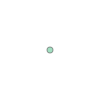

In [ ]:
# Eiffel Tower ("Tour Eiffel")

# WGS84 GEO DD X = 2.2952925, Y = 48.8581082
# WGS84 GEO UTM 30N X = -2170417, Y = 3073173

EIFFEL = Point(-2170417, 3073173)
EIFFEL

In [ ]:
pois['distance'] = pois.geometry.distance(EIFFEL).round(2)
pois.head()

name      place_type  \
element id                                                         
node    21662099                      Notre-Dame  ferry_terminal   
        24910582  Embarcadère du Chalet des Îles  ferry_terminal   
        25213384       Relais Total Du Pont Aval            fuel   
        25214653        Relais des Chaufourniers            fuel   
        27415802                 Paris 17 Wagram     post_office   

                                          geometry  distance  IsFood  
element id                                                            
node    21662099  POINT (-2166875.783 3070617.116)   4367.24   False  
        24910582  POINT (-2172551.004 3074860.804)   2720.78   False  
        25213384  POINT (-2173700.107 3071669.211)   3611.12   False  
        25214653  POINT (-2163938.164 3072941.293)   6482.98   False  
        27415802  POINT (-2168615.134 3075629.833)   3046.76   False

In [ ]:
eiffel_radius = pois[pois['distance']<2000]
eiffel_radius.shape

(2221, 5)

In [ ]:
eiffel_radius['repr'] = [get_text_embedding(text) for text in tqdm(eiffel_radius.name)]

eiffel_radius.head()

100%|██████████| 2221/2221 [01:38<00:00, 22.63it/s]
/usr/local/lib/python3.12/dist-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


name   place_type  \
element id                                                        
node    29434739             Paris École Militaire  post_office   
        241110355           Bibliothèque Vaugirard      library   
        243842886  Parking Quai branly-Tour Eiffel      parking   
        251758250                            Qasim   restaurant   
        251758251                             Diep   restaurant   

                                           geometry  distance  IsFood  \
element id                                                              
node    29434739   POINT (-2169730.829 3072508.741)    955.02   False   
        241110355   POINT (-2170986.15 3071280.681)   1976.06   False   
        243842886  POINT (-2169980.249 3073401.602)    492.96   False   
        251758250  POINT (-2168744.635 3074071.367)   1898.39    True   
        251758251   POINT (-2169276.917 3074129.84)   1488.40    True   

                                                                repr  
element id                                                            
node    29434739   [0.7380602359771729, 0.4176127314567566, 0.588...  
        241110355  [0.7727096080780029, 0.5499468445777893, 0.106...  
        243842886  [1.5052865743637085, 0.5771607756614685, 0.333...  
        251758250  [2.1504743099212646, 1.3921866416931152, -0.49...  
        251758251  [1.0278288125991821, -0.06918923556804657, -0....

In [ ]:
food = get_text_embedding("I want something to eat")

cosine_similarity = lambda vec1, vec2: np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

eiffel_radius['L2'] = eiffel_radius.repr.apply(lambda ary: ((food-ary)**2).mean())
eiffel_radius['L1'] = eiffel_radius.repr.apply(lambda ary:  np.abs(food-ary).mean())
eiffel_radius['CS'] = eiffel_radius.repr.apply(lambda ary:  cosine_similarity(food,ary))

eiffel_radius.head()

/usr/local/lib/python3.12/dist-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.12/dist-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.12/dist-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

name   place_type  \
element id                                                        
node    29434739             Paris École Militaire  post_office   
        241110355           Bibliothèque Vaugirard      library   
        243842886  Parking Quai branly-Tour Eiffel      parking   
        251758250                            Qasim   restaurant   
        251758251                             Diep   restaurant   

                                           geometry  distance  IsFood  \
element id                                                              
node    29434739   POINT (-2169730.829 3072508.741)    955.02   False   
        241110355   POINT (-2170986.15 3071280.681)   1976.06   False   
        243842886  POINT (-2169980.249 3073401.602)    492.96   False   
        251758250  POINT (-2168744.635 3074071.367)   1898.39    True   
        251758251   POINT (-2169276.917 3074129.84)   1488.40    True   

                                                                repr  \
element id                                                             
node    29434739   [0.7380602359771729, 0.4176127314567566, 0.588...   
        241110355  [0.7727096080780029, 0.5499468445777893, 0.106...   
        243842886  [1.5052865743637085, 0.5771607756614685, 0.333...   
        251758250  [2.1504743099212646, 1.3921866416931152, -0.49...   
        251758251  [1.0278288125991821, -0.06918923556804657, -0....   

                         L2        L1        CS  
element id                                       
node    29434739   0.472155  0.549817  0.756288  
        241110355  0.447244  0.537225  0.768629  
        243842886  0.445518  0.532689  0.777816  
        251758250  0.505318  0.560433  0.738117  
        251758251  0.466390  0.537964  0.756166

In [ ]:

Ks = [10, 25, 50, 100]

evaluation = {method:{k:0 for k in Ks} for method in [*eiffel_radius.columns[-3:]]+['distance']}

for method in [*eiffel_radius.columns[-3:]]+['distance']:
    for k in Ks:
      evaluation[method][k] = eiffel_radius.sort_values(method).IsFood[:k].mean()

evaluation = pd.DataFrame(evaluation)
evaluation


,L2,L1,CS,distance
10,1.00,1.00,0.10,0.40
25,0.92,0.96,0.32,0.52
50,0.96,0.96,0.36,0.48
100,0.96,0.95,0.29,0.51
